In [1]:
!git clone https://github.com/AlexeyAB/darknet



Cloning into 'darknet'...
remote: Enumerating objects: 14654, done.
remote: Total 14654 (delta 0), reused 0 (delta 0), pack-reused 14654
Receiving objects: 100% (14654/14654), 13.23 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (9976/9976), done.


In [2]:
%cd darknet


/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
!/usr/local/cuda/bin/nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!make


mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
!ls

3rdparty	darknet			include		       results
backup		DarknetConfig.cmake.in	json_mjpeg_streams.sh  scripts
build		darknet_images.py	LICENSE		       src
build.ps1	darknet.py		Makefile	       video_yolov3.sh
build.sh	darknet_video.py	net_cam_v3.sh	       video_yolov4.sh
cfg		data			net_cam_v4.sh
cmake		image_yolov3.sh		obj
CMakeLists.txt	image_yolov4.sh		README.md


In [ ]:
!cp /content/drive/MyDrive/darknet53.conv.74 /content/darknet

!cp /content/drive/MyDrive/obj/* /content/darknet/data/obj


In [ ]:
import os

path, dirs, files = next(os.walk("/content/darknet/data/obj"))
file_count = len(files)
print(file_count)


200


In [ ]:
!./darknet detector train data/obj.data cfg/yolov3-custom-akk.cfg darknet53.conv.74 -dont_show


Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.845731), count: 5, class_loss = 0.000122, iou_loss = 0.085962, total_loss = 0.086084 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 224785, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.879021), count: 4, class_loss = 0.000003, iou_loss = 0.039198, total_loss = 0.039201 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.0

In [3]:
weightsPath = "/content/drive/MyDrive/yolov3-custom-akk_last.weights"
configPath = "/content/darknet/cfg/yolov3-custom-akk.cfg"

In [6]:
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)


In [8]:
LABELS=['slice']
LABELS


['slice']

In [9]:
def predict(image):
    
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)
    color2 = (0,255, 0) 


    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = (255,0,0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x +15, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color2, 1)
    return image


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

import numpy as np
import cv2





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


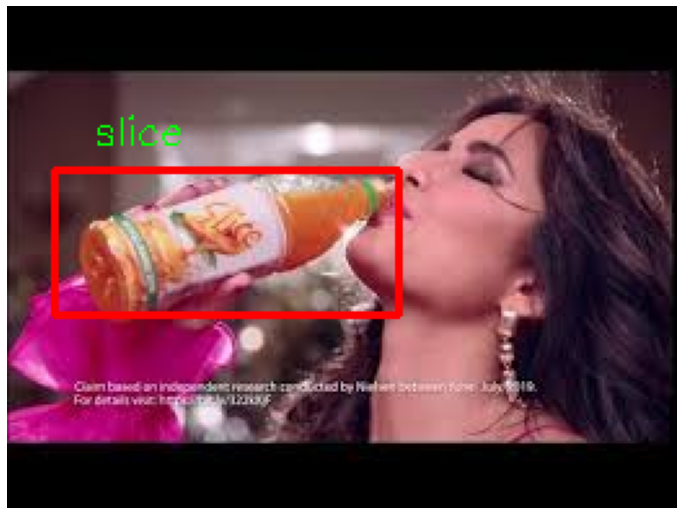

In [ ]:
img = cv2.imread("/content/darknet/data/download (2)5.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


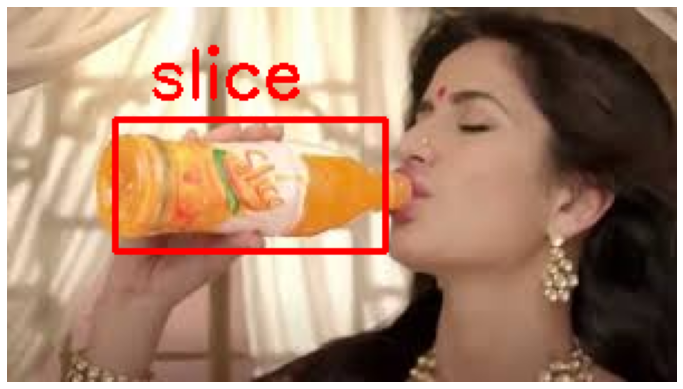

In [ ]:
img = cv2.imread("/content/darknet/data/downloa55d (2).jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


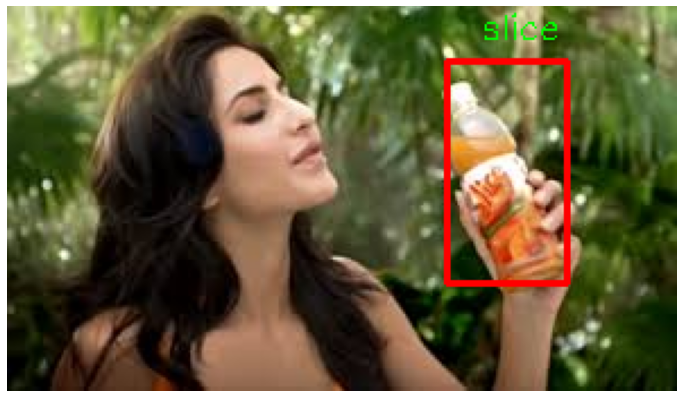

In [11]:
img = cv2.imread("/content/darknet/data/downloaddf (2).jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


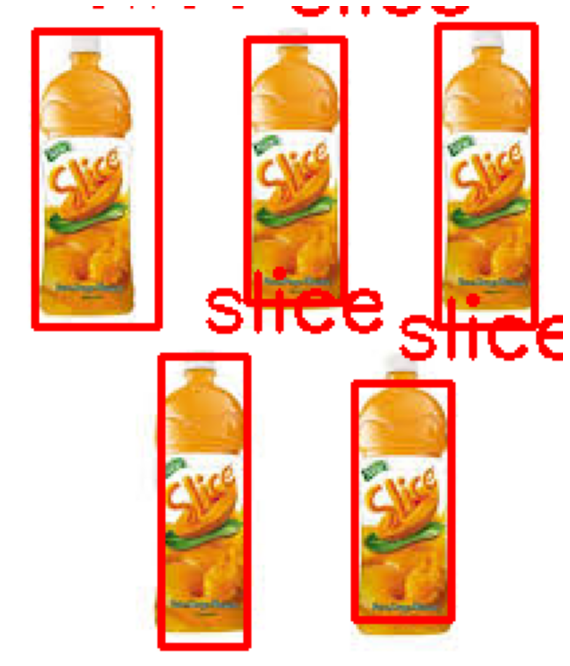

In [ ]:
img = cv2.imread("/content/darknet/data/img_t.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

In [ ]:
cap =cv2.VideoCapture('/content/drive/MyDrive/slice_adv_.mp4')

number_frame = 30.0 #higher frames better quality of the video
video_size = (1280,720)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('/content/drive/MyDrive/output_slice.mp4',fourcc, number_frame,video_size)

index=0
while True:
    ret,frame = cap.read() 
    
    if ret and index %5==0:
        
        frame = cv2.resize(frame, (1280,720))
        frame = predict(frame)
        cv2_imshow(frame)
        out.write(frame)

    index+=1

   
        
cap.release()   
out.release()
